In [1]:
%matplotlib inline 

import math
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import model
import model_utils
import preprocessing_utils

#to be put under model.py when I refactor
from tqdm.notebook import tqdm

In [2]:
torch.manual_seed(1234)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 500
batch_size = 32
lr = 0.01
patience = 10

num_timesteps_input = 7 # Default is 30 minutes
num_timesteps_output = 4 # Default is 10 minutes

In [4]:
raw_trunc_dir = "./data/raw/trunc/"
process_dir = "./data/processed/"

# overwrite = False means that the processing function will only run if the process data files do not exist
# overwrite = True => functions will run regardless
preprocessing_utils.processed(raw_trunc_dir, process_dir, overwrite=False)
A, X, metadata, cat2index, means, stds = preprocessing_utils.load(process_dir)

split_line1 = int(X.shape[2] * 0.6)
split_line2 = int(X.shape[2] * 0.8)

train_original_data = X[:, :, :split_line1]
val_original_data = X[:, :, split_line1:split_line2]
test_original_data = X[:, :, split_line2:]

training_input, training_target = preprocessing_utils.generate_dataset(train_original_data,
                                                   num_timesteps_input=num_timesteps_input,
                                                   num_timesteps_output=num_timesteps_output)
val_input, val_target = preprocessing_utils.generate_dataset(val_original_data,
                                         num_timesteps_input=num_timesteps_input,
                                         num_timesteps_output=num_timesteps_output)
test_input, test_target = preprocessing_utils.generate_dataset(test_original_data,
                                           num_timesteps_input=num_timesteps_input,
                                           num_timesteps_output=num_timesteps_output)

# input shape (num_samples ,num_vertices, num_timesteps_window, num_features)
# output shape (num_samples ,num_vertices, num_timesteps_window)
adj_mat = preprocessing_utils.get_normalized_adj(A)
adj_mat = torch.from_numpy(adj_mat).to(device)

In [5]:
def train(x_input, x_target, batch_size):
    """
    Train function per epoch
    """
    
    stgcn.train()
    
    num_samples = x_input.shape[0]
    shuffled_order = torch.randperm(num_samples)
    
    training_loss = []
    
    for i in range(math.ceil(num_samples / batch_size)):

        optimizer.zero_grad()
        
        start = i * batch_size
        batch = shuffled_order[start:start+batch_size]
        
        x_batch = x_input[batch].to(device = device)
        y_batch = x_target[batch].to(device = device)
        
        out = stgcn(adj_mat, x_batch)
        loss = loss_criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        
        training_loss.append(loss.detach().cpu().numpy())
        
    return sum(training_loss) / len(training_loss)

In [6]:
stgcn = model.Stgcn_Model(nodes_num = adj_mat.shape[0], features_num = training_input.shape[3],
                    input_timesteps = num_timesteps_input, num_output = num_timesteps_output).to(device = device)

optimizer = torch.optim.Adam(stgcn.parameters(), lr = lr)
loss_criterion = nn.MSELoss()

best_loss = float("inf")
early_stop = 0
best_weights = None

training_loss = []
validation_loss = []

pbar = tqdm(range(epochs))
for epoch in pbar:
    
    pbar.set_description(f"Epoch {epoch}")
    
    loss = train(training_input, training_target, batch_size)
    training_loss.append(loss)

    with torch.no_grad():
        val_loss = model_utils.validate(stgcn, loss_criterion, val_input, val_target, adj_mat, batch_size, device)
        validation_loss.append(val_loss.item())
    
    pbar.set_postfix(training_loss=loss, validation_loss=val_loss.item())
        
    if val_loss < best_loss:
        early_stop = 0
        best_loss = val_loss
        best_weights = copy.deepcopy(stgcn.state_dict())
    else:
        early_stop += 1
                
    if early_stop == patience:
        stgcn.load_state_dict(best_weights)
        break


#For Model saving purposes
stgcn.lr = lr 
stgcn.nodes_num = adj_mat.shape[0]
stgcn.features_num = training_input.shape[3]
stgcn.input_timesteps = num_timesteps_input
stgcn.num_output = num_timesteps_output

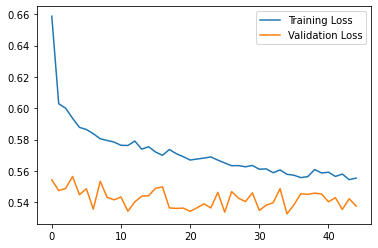

In [7]:
plt.plot(training_loss, label = 'Training Loss')
plt.plot(validation_loss, label = 'Validation Loss')
plt.legend()
plt.show()

In [19]:
torch.manual_seed(1234)

with torch.no_grad():
    test_loss = model_utils.validate(stgcn, loss_criterion, test_input, test_target, adj_mat, batch_size, device)
    print(test_loss)

tensor(0.4863)


In [20]:
results = model_utils.predict(stgcn, test_input, adj_mat)

In [ ]:
#print(preprocessing_utils.denormalize(results, stds[0], means[0]))

In [ ]:
#print(preprocessing_utils.denormalize(test_target, stds[0], means[0]))

In [21]:
model_utils.save_model(stgcn,optimizer)

Model has been saved to path : ./saved_models/20210425/19_56_10


In [22]:
loaded_model, loaded_optimizer = model_utils.load_model(path=None)

Loading model in path : ./saved_models/20210425/19_56_10


In [25]:
torch.manual_seed(1234)

#Testing loaded model
loaded_model.to(device)

with torch.no_grad():
    test_loss = model_utils.validate(loaded_model, loss_criterion, test_input, test_target, adj_mat, batch_size, device)
    print(test_loss)

tensor(0.4863)
